In [ ]:
'''
MobileNet v2 - Ablation Implementation

#Panel A - MPPI colored over the activation plot
#Panel B - Animate Impact over the activation plot
#Panel C - Inanimate Impact over the activation plot
#Panel D - Salience Diff (Animate-Inanimate) over the activation plot
#Panel E - Animate Salience over the activation plot (MPPI)
#Panel F - Inaniwe only have labels for 92 images). This resulting matrix shows how similar the neural patterns of activity are between images and is called the representational similarity matrix (RSM).mate Salience over the activation plot (MPPI)
#Panel G - Density Plot

Clean the RSA paper
'''

# Imports

In [1]:
#To hide warnings export PYTHONWARNINGS="ignore"
#Imports{

import os
from os.path import dirname
from os.path import join
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Change


import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import pickle
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from imageio import imread
from skimage.transform import resize
from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import keras
import tensorflow as tf
from keras import backend as K
#K.set_image_dim_ordering('tf')
from keras_applications import imagenet_utils as utils
from keras_applications import correct_pad
from keras.layers import Lambda

import PIL.Image
import seaborn as sns
import gc
import innvestigate
import innvestigate.utils
from vis.utils import utils as vis_utils
from keras.preprocessing.image import load_img, img_to_array
#}

Using TensorFlow backend.


# Model Definition

In [2]:
#Code snippet needed to read activation values from each layer of the pre-trained artificial neural networks
def get_activations(model, layer, X_batch):
    #keras.backend.function(inputs, outputs, updates=None)
    get_activations = keras.backend.function([model.layers[0].input, keras.backend.learning_phase()], [model.layers[layer].output,])
    #The learning phase flag is a bool tensor (0 = test, 1 = train)
    activations = get_activations([X_batch,0])
    return activations

In [3]:
'''
Cells 3 and 4 are focused on defining the MobileNetV2 architecture with Lambda layers for 
Ablation
'''
debug = False
backend= keras.backend
layers = keras.layers
models = keras.models
keras_utils = keras.utils
keras.backend.image_data_format() #Make sure image matrix in expected orientation

'channels_last'

In [4]:
"""MobileNet v2 models for Keras.

MobileNetV2 is a general architecture and can be used for multiple use cases.
Depending on the use case, it can use different input layer size and
different width factors. This allows different width models to reduce
the number of multiply-adds and thereby
reduce inference cost on mobile devices.

MobileNetV2 is very similar to the original MobileNet,
except that it uses inverted residual blocks with
bottlenecking features. It has a drastically lower
parameter count than the original MobileNet.
MobileNets support any input size greater
than 32 x 32, with larger image sizes
offering better performance.

The number of parameters and number of multiply-adds
can be modified by using the `alpha` parameter,
which increases/decreases the number of filters in each layer.
By altering the image size and `alpha` parameter,
all 22 models from the paper can be built, with ImageNet weights provided.

The paper demonstrates the performance of MobileNets using `alpha` values of
1.0 (also called 100 % MobileNet), 0.35, 0.5, 0.75, 1.0, 1.3, and 1.4

For each of these `alpha` values, weights for 5 different input image sizes
are provided (224, 192, 160, 128, and 96).


The following table describes the performance of
MobileNet on various input sizes:
------------------------------------------------------------------------
MACs stands for Multiply Adds

 Classification Checkpoint| MACs (M) | Parameters (M)| Top 1 Accuracy| Top 5 Accuracy
--------------------------|------------|---------------|---------|----|-------------
| [mobilenet_v2_1.4_224]  | 582 | 6.06 |          75.0 | 92.5 |
| [mobilenet_v2_1.3_224]  | 509 | 5.34 |          74.4 | 92.1 |
| [mobilenet_v2_1.0_224]  | 300 | 3.47 |          71.8 | 91.0 |
| [mobilenet_v2_1.0_192]  | 221 | 3.47 |          70.7 | 90.1 |
| [mobilenet_v2_1.0_160]  | 154 | 3.47 |          68.8 | 89.0 |
| [mobilenet_v2_1.0_128]  | 99  | 3.47 |          65.3 | 86.9 |
| [mobilenet_v2_1.0_96]   | 56  | 3.47 |          60.3 | 83.2 |
| [mobilenet_v2_0.75_224] | 209 | 2.61 |          69.8 | 89.6 |
| [mobilenet_v2_0.75_192] | 153 | 2.61 |          68.7 | 88.9 |
| [mobilenet_v2_0.75_160] | 107 | 2.61 |          66.4 | 87.3 |
| [mobilenet_v2_0.75_128] | 69  | 2.61 |          63.2 | 85.3 |
| [mobilenet_v2_0.75_96]  | 39  | 2.61 |          58.8 | 81.6 |
| [mobilenet_v2_0.5_224]  | 97  | 1.95 |          65.4 | 86.4 |
| [mobilenet_v2_0.5_192]  | 71  | 1.95 |          63.9 | 85.4 |
| [mobilenet_v2_0.5_160]  | 50  | 1.95 |          61.0 | 83.2 |
| [mobilenet_v2_0.5_128]  | 32  | 1.95 |          57.7 | 80.8 |
| [mobilenet_v2_0.5_96]   | 18  | 1.95 |          51.2 | 75.8 |
| [mobilenet_v2_0.35_224] | 59  | 1.66 |          60.3 | 82.9 |
| [mobilenet_v2_0.35_192] | 43  | 1.66 |          58.2 | 81.2 |
| [mobilenet_v2_0.35_160] | 30  | 1.66 |          55.7 | 79.1 |
| [mobilenet_v2_0.35_128] | 20  | 1.66 |          50.8 | 75.0 |
| [mobilenet_v2_0.35_96]  | 11  | 1.66 |          45.5 | 70.4 |

The weights for all 16 models are obtained and
translated from the Tensorflow checkpoints
from TensorFlow checkpoints found [here]
(https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/README.md).

# Reference

This file contains building code for MobileNetV2, based on
[MobileNetV2: Inverted Residuals and Linear Bottlenecks]
(https://arxiv.org/abs/1801.04381) (CVPR 2018)

Tests comparing this model to the existing Tensorflow model can be
found at [mobilenet_v2_keras]
(https://github.com/JonathanCMitchell/mobilenet_v2_keras)
"""
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

import os
import warnings
import numpy as np

# TODO Change path to v1.1
BASE_WEIGHT_PATH = ('https://github.com/JonathanCMitchell/mobilenet_v2_keras/'
                    'releases/download/v1.1/')

backend= keras.backend
layers = keras.layers
models = keras.models
keras_utils = keras.utils


def preprocess_input(x, **kwargs):
    """Preprocesses a numpy array encoding a batch of images.

    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].

    # Returns
        Preprocessed array.
    """
    return utils.preprocess_input(x, mode='tf', **kwargs)


# This function is taken from the original tf repo.
# It ensures that all layers have a channel number that is divisible by 8
# It can be seen here:
# https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def MobileNetV2(input_shape=None,
                alpha=1.0,
                include_top=True,
                weights='imagenet',
                input_tensor=None,
                pooling=None,
                classes=1000,
                lambda_mask = None,
                **kwargs):
    """Instantiates the MobileNetV2 architecture.

    # Arguments
        input_shape: optional shape tuple, to be specified if you would
            like to use a model with an input img resolution that is not
            (224, 224, 3).
            It should have exactly 3 inputs channels (224, 224, 3).
            You can also omit this option if you would like
            to infer input_shape from an input_tensor.
            If you choose to include both input_tensor and input_shape then
            input_shape will be used if they match, if the shapes
            do not match then we will throw an error.
            E.g. `(160, 160, 3)` would be one valid value.
        alpha: controls the width of the network. This is known as the
        width multiplier in the MobileNetV2 paper, but the name is kept for
        consistency with MobileNetV1 in Keras.
            - If `alpha` < 1.0, proportionally decreases the number
                of filters in each layer.
            - If `alpha` > 1.0, proportionally increases the number
                of filters in each layer.
            - If `alpha` = 1, default number of filters from the paper
                 are used at each layer.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor (i.e. output of
            `layers.Input()`)
            to use as image input for the model.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model
                will be the 4D tensor output of the
                last convolutional block.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional block, and thus
                the output of the model will be a
                2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.

    # Returns
        A Keras model instance.

    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape or invalid alpha, rows when
            weights='imagenet'
    """
    global backend, layers, models, keras_utils, debug
    #debug = True
    backend= keras.backend
    layers = keras.layers
    models = keras.models
    keras_utils = keras.utils

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top` '
                         'as true, `classes` should be 1000')

    # Determine proper input shape and default size.
    # If both input_shape and input_tensor are used, they should match
    if input_shape is not None and input_tensor is not None:
        try:
            is_input_t_tensor = backend.is_keras_tensor(input_tensor)
        except ValueError:
            try:
                is_input_t_tensor = backend.is_keras_tensor(
                    keras_utils.get_source_inputs(input_tensor))
            except ValueError:
                raise ValueError('input_tensor: ', input_tensor,
                                 'is not type input_tensor')
        if is_input_t_tensor:
            if backend.image_data_format == 'channels_first':
                if backend.int_shape(input_tensor)[1] != input_shape[1]:
                    raise ValueError('input_shape: ', input_shape,
                                     'and input_tensor: ', input_tensor,
                                     'do not meet the same shape requirements')
            else:
                if backend.int_shape(input_tensor)[2] != input_shape[1]:
                    raise ValueError('input_shape: ', input_shape,
                                     'and input_tensor: ', input_tensor,
                                     'do not meet the same shape requirements')
        else:
            raise ValueError('input_tensor specified: ', input_tensor,
                             'is not a keras tensor')

    # If input_shape is None, infer shape from input_tensor
    if input_shape is None and input_tensor is not None:

        try:
            backend.is_keras_tensor(input_tensor)
        except ValueError:
            raise ValueError('input_tensor: ', input_tensor,
                             'is type: ', type(input_tensor),
                             'which is not a valid type')

        if input_shape is None and not backend.is_keras_tensor(input_tensor):
            default_size = 224
        elif input_shape is None and backend.is_keras_tensor(input_tensor):
            if backend.image_data_format() == 'channels_first':
                rows = backend.int_shape(input_tensor)[2]
                cols = backend.int_shape(input_tensor)[3]
            else:
                rows = backend.int_shape(input_tensor)[1]
                cols = backend.int_shape(input_tensor)[2]

            if rows == cols and rows in [96, 128, 160, 192, 224]:
                default_size = rows
            else:
                default_size = 224

    # If input_shape is None and no input_tensor
    elif input_shape is None:
        default_size = 224

    # If input_shape is not None, assume default size
    else:
        if backend.image_data_format() == 'channels_first':
            rows = input_shape[1]
            cols = input_shape[2]
        else:
            rows = input_shape[0]
            cols = input_shape[1]

        if rows == cols and rows in [96, 128, 160, 192, 224]:
            default_size = rows
        else:
            default_size = 224

    input_shape = utils._obtain_input_shape(input_shape,
                                      default_size=default_size,
                                      min_size=32,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if backend.image_data_format() == 'channels_last':
        row_axis, col_axis = (0, 1)
    else:
        row_axis, col_axis = (1, 2)
    rows = input_shape[row_axis]
    cols = input_shape[col_axis]

    if weights == 'imagenet':
        if alpha not in [0.35, 0.50, 0.75, 1.0, 1.3, 1.4]:
            raise ValueError('If imagenet weights are being loaded, '
                             'alpha can be one of `0.35`, `0.50`, `0.75`, '
                             '`1.0`, `1.3` or `1.4` only.')

        if rows != cols or rows not in [96, 128, 160, 192, 224]:
            rows = 224
            warnings.warn('`input_shape` is undefined or non-square, '
                          'or `rows` is not in [96, 128, 160, 192, 224].'
                          ' Weights for input shape (224, 224) will be'
                          ' loaded as the default.')

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    channel_axis = 1 if backend.image_data_format() == 'channels_first' else -1

    first_block_filters = _make_divisible(32 * alpha, 8)
    x = layers.ZeroPadding2D(padding=correct_pad(backend, img_input, 3),
                             name='Conv1_pad')(img_input)
    x = layers.Conv2D(first_block_filters,
                      kernel_size=3,
                      strides=(2, 2),
                      padding='valid',
                      use_bias=False,
                      name='Conv1')(x)
    global start_index, end_index
    start_index = end_index = 0
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (default_size//2 * default_size//2 * first_block_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (default_size//2, default_size//2, first_block_filters))
        if debug:
            print('Conv_1',start_index,end_index)
    else:
        x_mask = np.ones(shape=((default_size//2, default_size//2, first_block_filters)))

    x_mask  = backend.variable(x_mask) #Numpy array to Tensor
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name='bn_Conv1')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (default_size//2 * default_size//2 * first_block_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (default_size//2, default_size//2, first_block_filters))
        if debug:
            print('Conv_1_BN',start_index,end_index)
    else:
        x_mask = np.ones(shape=((default_size//2, default_size//2, first_block_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.ReLU(6., name='Conv1_relu')(x)

    x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                            expansion=1, block_id=0, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                            expansion=6, block_id=1, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                            expansion=6, block_id=2, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                            expansion=6, block_id=3, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=4, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                            expansion=6, block_id=5, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=2,
                            expansion=6, block_id=6, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=7, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=8, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,
                            expansion=6, block_id=9, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=10, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=11, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1,
                            expansion=6, block_id=12, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=2,
                            expansion=6, block_id=13, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1,
                            expansion=6, block_id=14, lambda_mask=lambda_mask)
    x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1,
                            expansion=6, block_id=15, lambda_mask=lambda_mask)

    x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1,
                            expansion=6, block_id=16, lambda_mask=lambda_mask)

    # no alpha applied to last conv as stated in the paper:
    # if the width multiplier is greater than 1 we
    # increase the number of output channels
    if alpha > 1.0:
        last_block_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_block_filters = 1280

    x = layers.Conv2D(last_block_filters,
                      kernel_size=1,
                      use_bias=False,
                      name='Conv_1')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (x.shape[1] * x.shape[2]* last_block_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (x.shape[1], x.shape[2], last_block_filters))
        if debug:
            print('Conv_1',start_index,end_index)
    else:
        x_mask = np.ones(shape=((x.shape[1], x.shape[2], last_block_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.BatchNormalization(axis=channel_axis,
                                  epsilon=1e-3,
                                  momentum=0.999,
                                  name='Conv_1_bn')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (x.shape[1] * x.shape[2] * last_block_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (x.shape[1], x.shape[2], last_block_filters))
        if debug:
            print('Conv_1_bn',start_index,end_index)
    else:
        x_mask = np.ones(shape=((x.shape[1],x.shape[2], last_block_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.ReLU(6., name='out_relu')(x)

    if include_top:
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(classes, activation='softmax', use_bias=True, name='Logits')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = models.Model(inputs, x, name='mobilenetv2_%0.2f_%s' % (alpha, rows))

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            model_name = ('mobilenet_v2_weights_tf_dim_ordering_tf_kernels_' + str(alpha) + '_' + str(rows) + '.h5')
            weight_path = BASE_WEIGHT_PATH + model_name
            weights_path = keras_utils.get_file(model_name, weight_path, cache_subdir='models')
        else:
            model_name = ('mobilenet_v2_weights_tf_dim_ordering_tf_kernels_' + str(alpha) + '_' + str(rows) + '_no_top' + '.h5')
            weight_path = BASE_WEIGHT_PATH + model_name
            weights_path = keras_utils.get_file(model_name, weight_path, cache_subdir='models')
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)

    return model


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, lambda_mask = None):
    global debug
    channel_axis = 1 if backend.image_data_format() == 'channels_first' else -1
    in_channels = backend.int_shape(inputs)[channel_axis]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'block_{}_'.format(block_id)
    #print(prefix, inputs.shape,inputs.shape[0],inputs.shape[1] , in_channels, pointwise_conv_filters, pointwise_filters, filters)
    global start_index, end_index
    if block_id:
        # Expand
        x = layers.Conv2D(expansion * in_channels,
                          kernel_size=1,
                          padding='same',
                          use_bias=False,
                          activation=None,
                          name=prefix + 'expand')(x)
        #################
        if lambda_mask is not None:
            start_index = end_index
            end_index = start_index + (inputs.shape[1] * inputs.shape[2] * inputs.shape[3]*expansion)
            x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1], inputs.shape[2], inputs.shape[3]*expansion))
            if debug:
                print(prefix + 'expand',start_index,end_index)
        else:
            x_mask = np.ones(shape=((inputs.shape[1], inputs.shape[2], inputs.shape[3]*expansion)))

        x_mask  = backend.variable(x_mask)
        x = Lambda(lambda z: z * x_mask)(x)
        ####################
        x = layers.BatchNormalization(axis=channel_axis,
                                      epsilon=1e-3,
                                      momentum=0.999,
                                      name=prefix + 'expand_BN')(x)
  
        #################
        if lambda_mask is not None:
            start_index = end_index
            end_index = start_index + (inputs.shape[1] * inputs.shape[2] * inputs.shape[3]*expansion)
            x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1], inputs.shape[2], inputs.shape[3]*expansion))
            if debug:
                print(prefix + 'expand_BN',start_index,end_index)
        else:
            x_mask = np.ones(shape=((inputs.shape[1], inputs.shape[2], inputs.shape[3]*expansion)))

        x_mask  = backend.variable(x_mask)
        x = Lambda(lambda z: z * x_mask)(x)
        ####################
        x = layers.ReLU(6., name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'

    # Depthwise
    if stride == 2:
        x = layers.ZeroPadding2D(padding=correct_pad(backend, x, 3), name=prefix + 'pad')(x)
    x = layers.DepthwiseConv2D(kernel_size=3, strides=stride, activation=None, use_bias=False,padding='same' if stride == 1 else 'valid', name=prefix + 'depthwise')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (inputs.shape[1]//stride * inputs.shape[2]//stride * inputs.shape[3]*expansion)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1]//stride, inputs.shape[2]//stride, inputs.shape[3]*expansion))
        if debug:
            print(prefix + 'depthwise',start_index,end_index)
    else:
        x_mask = np.ones(shape=((inputs.shape[1]//stride, inputs.shape[2]//stride, inputs.shape[3]*expansion)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.BatchNormalization(axis=channel_axis,epsilon=1e-3,momentum=0.999, name=prefix + 'depthwise_BN')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (inputs.shape[1]//stride * inputs.shape[2]//stride * inputs.shape[3]*expansion)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1]//stride, inputs.shape[2]//stride, inputs.shape[3]*expansion))
        if debug:
            print(prefix + 'depthwise_BN',start_index,end_index)
    else:
        x_mask = np.ones(shape=((inputs.shape[1]//stride, inputs.shape[2]//stride, inputs.shape[3]*expansion)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################

    x = layers.ReLU(6., name=prefix + 'depthwise_relu')(x)

    # Project
    x = layers.Conv2D(pointwise_filters, kernel_size=1, padding='same', use_bias=False, activation=None, name=prefix + 'project')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (inputs.shape[1]//stride * inputs.shape[2]//stride * pointwise_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1]//stride, inputs.shape[2]//stride, pointwise_filters))
        if debug:
            print(prefix + 'project',start_index,end_index)
    else:
        x_mask = np.ones(shape=((inputs.shape[1]//stride, inputs.shape[2]//stride, pointwise_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.BatchNormalization(axis=channel_axis, epsilon=1e-3, momentum=0.999, name=prefix + 'project_BN')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (inputs.shape[1]//stride * inputs.shape[2]//stride * pointwise_filters)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (inputs.shape[1]//stride, inputs.shape[2]//stride, pointwise_filters))
        if debug:
            print(prefix + 'project_BN',start_index,end_index)
    else:
        x_mask = np.ones(shape=((inputs.shape[1]//stride, inputs.shape[2]//stride, pointwise_filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################

    if in_channels == pointwise_filters and stride == 1:
        return layers.Add(name=prefix + 'add')([inputs, x])
    return x

In [5]:
#Function to pre-process the input image to ensure uniform size and color
def preprocess_image_batch(image_paths, img_size=None, crop_size=None, color_mode='rgb', out=None):
    """
    Consistent preprocessing of images batches
    :param image_paths: iterable: images to process
    :param crop_size: tuple: crop images if specified
    :param img_size: tuple: resize images if specified
    :param color_mode: Use rgb or change to bgr mode based on type of model you want to use
    :param out: append output to this iterable if specified
    """
    img_list = []

    for im_path in image_paths:
        size = 224
        ret = PIL.Image.open(im_path)
        ret = ret.resize((size, size))
        ret = np.asarray(ret, dtype=np.uint8).astype(np.float32)
        if ret.ndim == 2:
            ret.resize((size, size, 1))
            ret = np.repeat(ret, 3, axis=-1)
        #ret = ret.transpose((2, 0, 1))
        #ret = np.flip(ret,0)
        global backend
        x = preprocess_input(ret, 
            data_format=backend.image_data_format())
        img_list.append(x)


    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        print(im_path)
        raise ValueError('when img_size and crop_size are None, images'
                ' in image_paths must have the same shapes.')

    if out is not None and hasattr(out, 'append'):
        out.append(img_batch)
    else:
        return img_batch

In [6]:
#Function to predict the top 5 accuracy
def top5accuracy(true, predicted):
    assert len(true) == len(predicted)
    result = []
    flag  = 0
    for i in range(len(true)):
        flag  = 0
        temp = true[i]
        for j in predicted[i][0:5]:
            if j == temp:
                flag = 1
                break
        if flag == 1:
            result.append(1)
        else:
            result.append(0)
    counter = 0.
    for i in result:
        if i == 1:
            counter += 1.
    error = 1.0 - counter/float(len(result))
    #print len(np.where(np.asarray(result) == 1)[0])
    return len(np.where(np.asarray(result) == 1)[0]), error

In [7]:
#Load the details of all the 1000 classes and the function to conver the synset id to words{
meta_clsloc_file = '../../data/meta_clsloc.mat'
synsets = loadmat(meta_clsloc_file)['synsets'][0]
synsets_imagenet_sorted = sorted([(int(s[0]), str(s[1][0])) for s in synsets[:1000]],key=lambda v: v[1])
corr = {}
for j in range(1000):
    corr[synsets_imagenet_sorted[j][0]] = j

corr_inv = {}
for j in range(1, 1001):
    corr_inv[corr[j]] = j

def id_to_words(id_):
    return synsets[corr_inv[id_] - 1][2][0]

def pprint_output(out, n_max_synsets=10):
    wids = []
    best_ids = out.argsort()[::-1][:10]
    for u in best_ids:
        wids.append(str(synsets[corr_inv[u] - 1][1][0]))
    #print('%.2f' % round(100 * out[u], 2) + ' : ' + id_to_words(u)+' '+ str(synsets[corr_inv[u] - 1][1][0]))
    return wids

In [8]:
#Code snippet to load the ground truth labels to measure the performance{
truth = {}
with open('../../data/ILSVRC2014_clsloc_validation_ground_truth.txt') as f:
    line_num = 1
    for line in f.readlines():
        ind_ = int(line)
        temp  = None
        for i in synsets_imagenet_sorted:
            if i[0] == ind_:
                temp = i
        #print ind_,temp
        if temp != None:
            truth[line_num] = temp
        else:
            print('##########', ind_)
            pass
        line_num += 1
#}

# Step 0 - Getting activations and saving them into pkl files

In [ ]:
# Loading the folder to be procesed from command line{
#Animate/Inanimate
p = 'inanimate' #Change
tmp = p.replace('/','_')
url_path = '../../data/'+p+'/'
print(tmp)

#Output Folder
folder = 'pkl_mobile'
p_num = 1
#}

In [ ]:
# Prepare the image list and pre-process them{
true_wids = []
im_list = []
for i in os.listdir(url_path):
    if not i.startswith('~') and not i.startswith('.'):
        #print i, truth
        temp = i.split('.')[0].split('_')[2]
        true_wids.append(truth[int(temp)][1])
        im_list.append(url_path+i)
print(len(im_list))

In [ ]:
im = preprocess_image_batch(im_list,img_size=(256,256), crop_size=(224,224), color_mode="rgb")

In [ ]:
# Model parmeters and running the model from the loaded weights{


model_name = 'MobileNetV2'
model = MobileNetV2( input_shape=None,
    alpha=0.35,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    lambda_mask = np.ones(5725552),
    classes=1000,
    classifier_activation="softmax")
#KFold
k = 4

im_train, im_test = train_test_split(im_list, test_size=0.25, random_state=42)
#}

In [ ]:
model.summary()

In [ ]:
im_temp = preprocess_image_batch(im_train,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
i = 0
for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) > 0:
        print(layer.name, len(weights), weights[0].shape)
        if len(weights) > 0:
            activations = get_activations(model,i,im_temp)
            print(i, len(activations), activations[0].shape)
    i += 1

In [ ]:
#Training data pkl
fp_name = '../../data/pkl_mobile/'+str(p)+'_'+str(model_name)+'_train_no_lesion_performance.txt'
fp = open(fp_name,'a+')
im_temp = preprocess_image_batch(im_train,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
out = model.predict(im_temp)

true_valid_wids = []
for i in im_train:
        temp1 = i.split('/')[4]
        temp = temp1.split('.')[0].split('_')[2]
        true_valid_wids.append(truth[int(temp)][1])

predicted_valid_wids = []
for i in range(len(im_train)):
    #print(im_list[i], pprint_output(out[i]), true_wids[i])
    predicted_valid_wids.append(pprint_output(out[i]))

count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

fp.write(str(p)+' '+str(count)+' '+str(len(im_train))+' '+str(error)+'\n')


print(len(true_valid_wids), len(predicted_valid_wids), len(im_train))
print(count, error)


#}
# Code snippet to get the activation values and saving information{
data = np.array([])

i = 0
result ={}
for layer in model.layers:
    weights = layer.get_weights()
    #print(layer.name, len(weights))
    if len(weights) > 0:
        activations = get_activations(model,i,im_temp)
        if result.get(layer.name, None) is None:
            result[layer.name] = activations[0]
            temp = np.mean(activations[0], axis=0).ravel()
            if layer.name != 'Logits':
                print(layer.name,len(weights),len(activations), activations[0].shape, np.mean(activations[0], axis=0).shape, temp.shape)
                data = np.append(data, temp)
    i += 1

print(data.shape)
fp.close()
with open('../../data/pkl_mobile/'+str(p)+'_train_'+model_name+'.pkl', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
#Testing data pkl
fp_name = '../../data/pkl_mobile/'+str(p)+'_'+str(model_name)+'_test_no_lesion_performance.txt'
fp = open(fp_name,'a+')

im_temp = preprocess_image_batch(im_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
out = model.predict(im_temp,batch_size=64)

true_valid_wids = []
for i in im_test:
        temp1 = i.split('/')[4]
        temp = temp1.split('.')[0].split('_')[2]
        true_valid_wids.append(truth[int(temp)][1])

predicted_valid_wids = []
for i in range(len(im_test)):
    #print im_list[i], pprint_output(out[i]), true_wids[i]
    predicted_valid_wids.append(pprint_output(out[i]))

count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

fp.write(str(p)+' '+str(count)+' '+str(len(im_test))+' '+str(error)+'\n')


print(len(true_valid_wids), len(predicted_valid_wids), len(im_test))
print(count, error)


#}
# Code snippet to get the activation values and saving information{
data = np.array([])

i = 0
result ={}
for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) > 0:
        activations = get_activations(model,i,im_temp)
        if result.get(layer.name, None) is None:
            result[layer.name] = activations[0]
            temp = np.mean(activations[0], axis=0).ravel()
            if layer.name != 'Logits':
                print(layer.name,len(weights),len(activations), activations[0].shape, np.mean(activations[0], axis=0).shape, temp.shape)
                data = np.append(data, temp)
    i += 1
    
print(data.shape)
fp.close()
with open('../../data/pkl_mobile/'+str(p)+'_test_'+model_name+'.pkl', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
out_r = []

image_list_test = '../../data/pkl_mobile/'+p+'_'+str(model_name)+'_image_list_valid.txt'
with open(image_list_test,'w+') as f:
    for i in im_test:
        f.write(i+'\n')

kf = KFold(n_splits= k)
fold = 1
fp_name = '../../data/pkl_mobile/'+str(p)+'_no_lesion_performance.txt'
fp = open(fp_name,'a+')
for train_index, valid_index in kf.split(im_train):
    print("Starting Fold: ", fold)
    im_valid_train = [im_train[i] for i in train_index] 
    im_valid_test = [im_train[i] for i in valid_index]
    
    image_list_train = '../../data/pkl_mobile/'+p+'_image_list_train_fold_'+str(fold)+'.txt'
    with open(image_list_train,'w+') as f:
        for i in im_valid_train:
            f.write(i+'\n')
    
    image_list_valid = '../../data/pkl_mobile/'+p+'_image_list_valid_fold_'+str(fold)+'.txt'
    with open(image_list_valid,'w+') as f:
        for i in im_valid_test:
            f.write(i+'\n')
    
   
    im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
    out = model.predict(im_temp,batch_size=64)

    true_valid_wids = []
    for i in im_valid_test:
            temp1 = i.split('/')[4]
            temp = temp1.split('.')[0].split('_')[2]
            true_valid_wids.append(truth[int(temp)][1])
    
    predicted_valid_wids = []
    for i in range(len(im_valid_test)):
        #print im_list[i], pprint_output(out[i]), true_wids[i]
        predicted_valid_wids.append(pprint_output(out[i]))
        
    count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)
    
    fp.write(str(p)+' '+str(fold)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+'\n')

    
    print(len(true_valid_wids), len(predicted_valid_wids), len(im_valid_test))
    print(count, error)
    
    
    #}
    # Code snippet to get the activation values and saving information{
    data = np.array([])

    i = 0
    result ={}
    for layer in model.layers:
        weights = layer.get_weights()
        if len(weights) > 0:
            activations = get_activations(model,i,im_temp)
            if result.get(layer.name, None) is None:
                result[layer.name] = activations[0]
                temp = np.mean(activations[0], axis=0).ravel()
                if layer.name != 'Logits':
                    print(layer.name,len(weights),len(activations), activations[0].shape, np.mean(activations[0], axis=0).shape, temp.shape)
                    data = np.append(data, temp)
        i += 1
    print(data.shape)
    out_r.append(data)
    fold += 1
    
fp.close()

In [ ]:
#Saving all the data into pkl files
for i in range(k):
    name = p+'_fold_'+str(i+1)+'_train_'+model_name
    out_data = out_r[i]
    with open('../../data/pkl_mobile/'+name+'.pkl', 'wb') as f:
        pickle.dump(out_data, f)
    print(name, len(out_data))

In [ ]:
import gc
from keras import backend as K 

del model
K.clear_session()
gc.collect()

# Step 1 - Cross-Validation to find best value of k and corresponding indices

In [ ]:
#%%time
#Version 1 - Reading pkl files from step 0 and clustering it{
data_path = '../../data/pkl_mobile/'
classes = ['animate','inanimate']
from sklearn.cluster import MiniBatchKMeans
import gc
result= {}

k = 4 #Total Number of folds
fold = 1

for i in range(k): 
    print('Perfoming Fold: ', fold)
    clf_result = {}
    
    if os.path.exists('../../data/pkl_mobile/kmeans_first_'+str(fold)+'_'+model_name+'.pkl'):
        with open('../../data/pkl_mobile/kmeans_first_'+str(fold)+'_'+model_name+'.pkl',"rb") as f:
            X_new,pred_kmeans,kmeans = pickle.load(f)
    else:   
        with open(data_path+classes[0]+'_fold_'+str(fold)+'_train_'+model_name+'.pkl','rb') as f:
            X_fold = pickle.load(f)
        with open(data_path+classes[1]+'_fold_'+str(fold)+'_train_'+model_name+'.pkl','rb') as f:
            y_fold = pickle.load(f)

        X = np.column_stack((X_fold,y_fold))
        kmeans = MiniBatchKMeans(n_clusters=57255,random_state=42).fit(X) #100x reduction
        #print kmeans.cluster_centers_
        pred_kmeans = kmeans.predict(X)
        X_new = kmeans.cluster_centers_

        with open('../../data/pkl_mobile/kmeans_first_'+str(fold)+'_'+model_name+'.pkl', 'wb') as handle:
            pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)

    #DO CLUSTERING AND GET CLUSTERS
    
    from sklearn.cluster import KMeans

    from sklearn.mixture import GaussianMixture
    
    method ='GMM'
    print(method)
    for j in range(1,14,1):
 
        clf_result[j] = {}

        # clf = KMeans(n_clusters=j)    
        clf = GaussianMixture(n_components=2**j, covariance_type='full', random_state=42)
        y_pred = clf.fit_predict(X_new)
        #print clf.cluster_centers_

        for label in set(y_pred):
            print('Cluster: ',j,'Label: ', label)
            
            #Lesioning and measuring performance
            pred = y_pred.copy()
            loc = np.where(pred==label)
            loc_temp = kmeans.predict(X_new[loc[0]])
            loc_new =[]
            for entry in set(loc_temp):
                temp = np.where(pred_kmeans==entry)[0]
                loc_new.extend(temp)

            lambda_mask = np.ones(shape=((5725552,)))   
            lambda_mask[loc_new] = 0.

            #plt.scatter(X[:,0],X[:,1], c=y_pred) 
            #Change Model
            model = MobileNetV2(include_top=True,
                                weights="imagenet",
                                input_tensor=None,
                                input_shape=None,
                                alpha = 0.35,
                                pooling=None,
                                classes=1000,
                                lambda_mask=lambda_mask,
                                classifier_activation="softmax")
            flag = 0
            dprime = 0.
            for p in classes:
                im_valid_test = []
                image_list_valid = '../../data/pkl_mobile/'+p+'_image_list_valid_fold_'+str(fold)+'.txt'
                with open(image_list_valid,'r') as f:
                    for line in f.readlines():
                        im_valid_test.append(line.strip('\n'))
                im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
                out = model.predict(im_temp,batch_size=64)

                true_valid_wids = []
                for i in im_valid_test:
                        temp1 = i.split('/')[4]
                        temp = temp1.split('.')[0].split('_')[2]
                        true_valid_wids.append(truth[int(temp)][1])

                predicted_valid_wids = []
                for i in range(len(im_valid_test)):
                    #print im_list[i], pprint_output(out[i]), true_wids[i]
                    predicted_valid_wids.append(pprint_output(out[i]))

                count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)
                print(str(p)+' '+str(fold)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error))
                
                if flag == 0:
                    dprime = error
                    flag = 1
                else:
                    dprime -= error
                    
            keras.backend.clear_session()
            gc.collect()
            del model
            clf_result[j][label] = [dprime,loc_new]
    
    with open('../../data/pkl_mobile/'+str(method)+'_multi_scree_fold_'+str(fold)+'_'+model_name+'.pkl', 'wb') as handle:
        pickle.dump(clf_result, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    result[fold] = clf_result
    fold += 1
#}

In [9]:
#Code to generate average scree plot
model_name = 'MobileNetV2'
method = 'GMM'
folder_name='pkl_mobile'
number_of_neurons = 5725552
k = 4
result ={}
for i in range(1,k+1,1):
    name = '../../data/'+folder_name+'/'+str(method)+'_multi_scree_fold_'+str(i)+'_'+model_name+'.pkl'   #CHANGE
    with open(name,"rb") as f:
        result[i] = pickle.load(f)

In [10]:
from functools import reduce
import itertools
fold = 1
loc_ana = {}
loc_ina = {}
pi_ana = {}
pi_ina = {}
loc_ana_avg = []
loc_ina_avg = []
for i in range(4):
    pi_scores = [i[0] for i in result[fold][8].values()]
    pi_scores_ina = [i[0] for i in result[fold][9].values()]
    #ana = int(list(pi_scores).index(max(pi_scores)))
    #ina = int(list(pi_scores).index(min(pi_scores)))
    ana = sorted(range(len(pi_scores)), key=lambda i: pi_scores[i],reverse=True)[0:12]
    ina = sorted(range(len(pi_scores)), key=lambda i: pi_scores_ina[i])[0:50]
    pi_ana[fold] = [result[fold][8][i][0] for i in ana]
    pi_ina[fold] = [result[fold][9][i][0] for i in ina]
    #print(fold, ana, ana_mppi_score)
    #print('####',fold, ina, ina_mppi_score)
    #print(fold, ina, [result_validate[fold][256][i][1] for i in ina])
    loc_ana[fold] =  list(itertools.chain.from_iterable([result[fold][8][i][1] for i in ana]))
    loc_ina[fold] = list(itertools.chain.from_iterable([result[fold][9][i][1] for i in ina]))
    fold+=1
loc_ana_avg = list(reduce(set.intersection, [set(item) for item in loc_ana.values()]))
loc_ina_avg = list(reduce(set.intersection, [set(item) for item in loc_ina.values()]))
print(len(loc_ana_avg),len(loc_ina_avg))

17637 18193


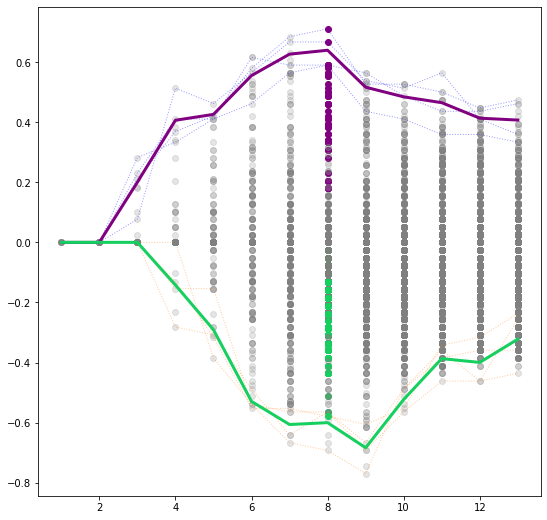

In [11]:
fig = plt.figure(1,figsize=(9,9))
ax1 = fig.add_subplot(111)
anat_avg = np.zeros(13,)
inat_avg = np.zeros(13,)
for f in range(1,5,1):
    clf_result = result[f]
    X = range(1,14,1)
    xticks = []
    x2ticks = []
    anat = []
    inat = []
    for cl in X:
        xticks.append(2**cl)
        x2ticks.append(number_of_neurons//2**cl)
        i = 0
        temp = []
        for item in clf_result[cl].keys():
            if cl == 8:
                if clf_result[cl][item][0] in pi_ana[f]:
                    plt.plot(cl,clf_result[cl][item][0],'go',color='#800080')
                elif clf_result[cl][item][0] in pi_ina[f]:
                    plt.plot(cl,clf_result[cl][item][0],'go',color='#15CF5F')
                else:
                    plt.plot(cl,clf_result[cl][item][0],'go',color='grey',alpha=0.2)
            else:
                plt.plot(cl,clf_result[cl][item][0],'go',color='grey',alpha=0.2)
            temp.append(clf_result[cl][item][0])
            i += 1
        anat.append(np.max(temp))
        inat.append(np.min(temp))
     
    anat_avg = np.add(anat_avg,anat)
    inat_avg = np.add(inat_avg,inat)
    plt.plot(X,anat, color='b',linewidth=1, alpha=0.4,linestyle='dotted')
    plt.plot(X,inat, color='C1',linewidth=1,alpha=0.4,linestyle='dotted')

for i in range(13):
    anat_avg[i] = anat_avg[i] / 4.
    inat_avg[i] = inat_avg[i] / 4.
    
plt.plot(X,anat_avg, color='#800080',linewidth=3,label='Animate')
plt.plot(X,inat_avg, color='#15CF5F',linewidth=3, label ='Inanimate')

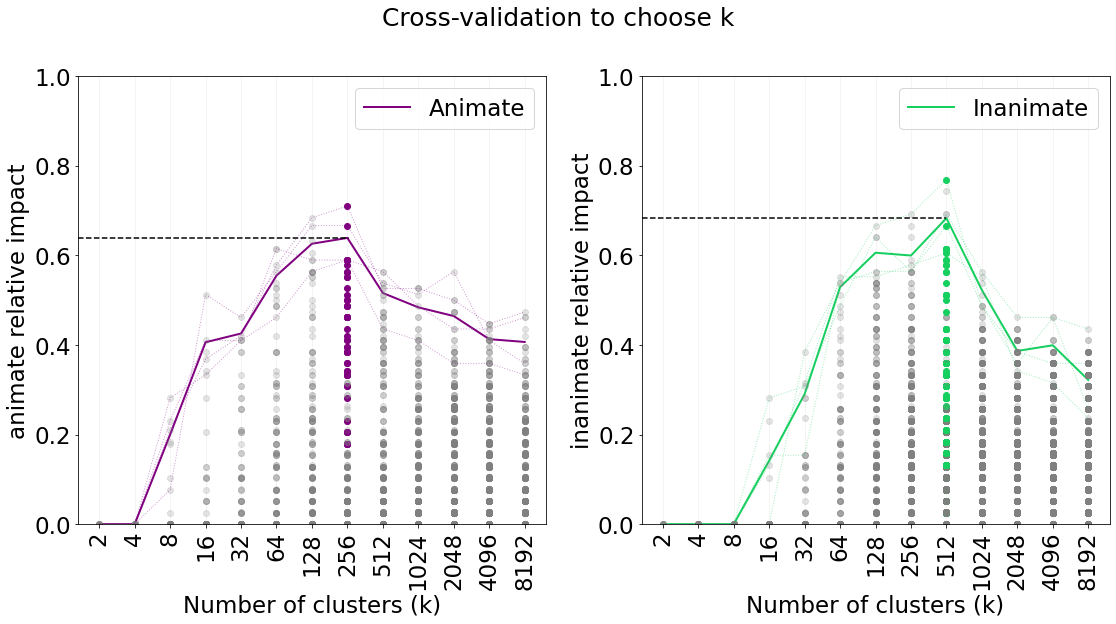

In [12]:
fig, ax = plt.subplots(figsize=(16,9))
matplotlib.rcParams["font.size"] = 23
fig.suptitle('Cross-validation to choose k', fontsize=25)


plt.subplot(1, 2, 1)
plt.plot(range(1,14,1), anat_avg, color='#800080', linewidth=2, label='Animate')
plt.grid(axis='x', color='0.95')
plt.xticks(range(1,14,1),xticks, rotation=90)
plt.axhline(y=max(anat_avg), color='black', linestyle='--', xmin=0, xmax=0.58)
plt.ylim([0,1])
plt.ylabel('animate relative impact')
plt.xlabel('Number of clusters (k)')

for f in range(1,5,1):
    clf_result = result[f]
    X = range(1,14,1)
    anat = []
    for cl in X:
        i = 0
        temp =[]
        for item in clf_result[cl].keys():
            if cl == 8:
                if clf_result[cl][item][0] in pi_ana[f]:
                    plt.plot(cl,clf_result[cl][item][0],'go',color='#800080')
                else:
                    plt.plot(cl,clf_result[cl][item][0],'go',color='grey',alpha=0.2)
            else:
                plt.plot(cl,clf_result[cl][item][0],'go',color='grey',alpha=0.2)
            i += 1
            temp.append(clf_result[cl][item][0])
        anat.append(np.max(temp))
    plt.plot(range(1,14,1),anat, color='#800080',linewidth=1, alpha=0.4,linestyle='dotted')
plt.legend()

inat_avg_pos = -1 * inat_avg
plt.subplot(1, 2, 2)
plt.plot(range(1,14,1), inat_avg_pos, color='#15CF5F', linewidth=2, label='Inanimate')
plt.grid(axis='x', color='0.95')
plt.xticks(range(1,14,1),xticks, rotation=90)
plt.axhline(y=max(inat_avg_pos), color='black', linestyle='--', xmin=0, xmax=0.65)
plt.ylabel('inanimate relative impact')
plt.xlabel('Number of clusters (k)')
plt.ylim([0,1])

for f in range(1,5,1):
    clf_result = result[f]
    X = range(1,14,1)
    inat = []
    for cl in X:
        i = 0
        temp =[]
        for item in clf_result[cl].keys():
            if cl == 9:
                if clf_result[cl][item][0] in pi_ina[f]:
                    plt.plot(cl,-1*clf_result[cl][item][0],'go',color='#15CF5F')
                else:
                    plt.plot(cl,-1*clf_result[cl][item][0],'go',color='grey',alpha=0.2)
            else:
                plt.plot(cl,-1*clf_result[cl][item][0],'go',color='grey',alpha=0.2)
            i += 1
            temp.append(-1*clf_result[cl][item][0])
        inat.append(np.max(temp))
    plt.plot(range(1,14,1),inat, color='#15CF5F',linewidth=1, alpha=0.4,linestyle='dotted')
plt.legend()

plt.tight_layout()
#plt.savefig('../../results/mobile_cross_fold.png')

In [ ]:
import gc
from keras import backend as K 
#del model
K.clear_session()
gc.collect()

# Step 2 - Using the k from Step 1 to do the final groupings

In [9]:
folder = 'pkl_mobile'
model_name = 'MobileNetV2'
debug = False

In [18]:
#%%time
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
#Testing on test data{
data_path = '../../data/'+folder+'/'
classes = ['animate','inanimate']

result = {}

with open(data_path+classes[0]+'_test_'+model_name+'.pkl','rb') as f:
        X_fold = pickle.load(f)
with open(data_path+classes[1]+'_test_'+model_name+'.pkl','rb') as f:
        y_fold = pickle.load(f)

X = np.column_stack((X_fold,y_fold))  
if os.path.exists('../../data/'+folder+'/kmeans_first_test_'+model_name+'.pkl'):
    with open('../../data/'+folder+'/kmeans_first_test_'+model_name+'.pkl',"rb") as f:
        X_new,pred_kmeans,kmeans = pickle.load(f)
else:   
   
    kmeans = MiniBatchKMeans(n_clusters=57255, #100x
                             random_state=42,
                             batch_size=6,
                             max_iter=10).fit(X)
    #print kmeans.cluster_centers_
    pred_kmeans = kmeans.predict(X)
    X_new = kmeans.cluster_centers_
    with open('../../data/'+folder+'/kmeans_first_test_'+model_name+'.pkl', 'wb') as handle:
        pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)

#DO CLUSTERING AND GET CLUSTERS


#import genieclust
#import hdbscan
#import smm

j = 256  #Set this value from scree plot!
method = 'GMM'
print(j)

clf = GaussianMixture(n_components=j, covariance_type='full',random_state=42)
temp = clf.fit(X_new)
y_pred = clf.predict(X_new)
#y_pred = clf.fit_predict(X_new)
print(set(y_pred))
#Z = clf.predict(X)

for label in set(y_pred):
    print('Cluster: ',j,'Label: ', label)

    #Lesioning and measuring performance
    pred = y_pred.copy()
    loc = np.where(pred==label)
    loc_temp = kmeans.predict(X_new[loc[0]])
    loc_new =[]
    for entry in set(loc_temp):
        temp = np.where(pred_kmeans==entry)[0]
        loc_new.extend(temp)

    lambda_mask = np.ones(shape=((5725552,)))
    lambda_mask[loc_new] = 0.

    #plt.scatter(X[:,0],X[:,1], c=y_pred) 
    model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)
    flag = 0
    dprime = 0.
    for p in classes:
        im_valid_test = []
        image_list_valid = '../../data/'+folder+'/'+p+'_MobileNetV2_image_list_test.txt'
        with open(image_list_valid,'r') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))
        im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")

        out = model.predict(im_temp,batch_size=32)
       
        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

        print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

        if flag == 0:
            dprime = error
            flag = 1
        else:
            dprime -= error
    keras.backend.clear_session()
    gc.collect()
    del model

    result[label] = dprime

256
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 

animate 18 39 0.5384615384615384 0.46153846153846156
inanimate 12 39 0.6923076923076923 0.3076923076923077
Cluster:  256 Label:  58
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 32 39 0.17948717948717952 0.8205128205128205
Cluster:  256 Label:  59
animate 30 39 0.23076923076923073 0.7692307692307693
inanimate 29 39 0.2564102564102564 0.7435897435897436
Cluster:  256 Label:  60
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 31 39 0.20512820512820518 0.7948717948717948
Cluster:  256 Label:  61
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cluster:  256 Label:  62
animate 31 39 0.20512820512820518 0.7948717948717948
inanimate 31 39 0.20512820512820518 0.7948717948717948
Cluster:  256 Label:  63
animate 31 39 0.20512820512820518 0.7948717948717948
inanimate 28 39 0.28205128205128205 0.717948717948718
Cluster:  256 Label:  64
animate 2 39 0.9487179487179487 0.05128205128205132
inanimate 1 39 0.9743

animate 32 39 0.17948717948717952 0.8205128205128205
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cluster:  256 Label:  122
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 32 39 0.17948717948717952 0.8205128205128205
Cluster:  256 Label:  123
animate 31 39 0.20512820512820518 0.7948717948717948
inanimate 31 39 0.20512820512820518 0.7948717948717948
Cluster:  256 Label:  124
animate 29 39 0.2564102564102564 0.7435897435897436
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cluster:  256 Label:  125
animate 30 39 0.23076923076923073 0.7692307692307693
inanimate 24 39 0.3846153846153846 0.6153846153846154
Cluster:  256 Label:  126
animate 27 39 0.3076923076923077 0.6923076923076923
inanimate 25 39 0.3589743589743589 0.6410256410256411
Cluster:  256 Label:  127
animate 31 39 0.20512820512820518 0.7948717948717948
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cluster:  256 Label:  128
animate 23 39 0.41025641025641024 0.5897435897435898
inanimate 28 39

animate 8 39 0.7948717948717949 0.20512820512820507
inanimate 0 39 1.0 0.0
Cluster:  256 Label:  187
animate 28 39 0.28205128205128205 0.717948717948718
inanimate 32 39 0.17948717948717952 0.8205128205128205
Cluster:  256 Label:  188
animate 30 39 0.23076923076923073 0.7692307692307693
inanimate 31 39 0.20512820512820518 0.7948717948717948
Cluster:  256 Label:  189
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 32 39 0.17948717948717952 0.8205128205128205
Cluster:  256 Label:  190
animate 33 39 0.15384615384615385 0.8461538461538461
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cluster:  256 Label:  191
animate 33 39 0.15384615384615385 0.8461538461538461
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cluster:  256 Label:  192
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cluster:  256 Label:  193
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 32 39 0.17948717948717952 0.820512

inanimate 32 39 0.17948717948717952 0.8205128205128205
Cluster:  256 Label:  252
animate 36 39 0.07692307692307687 0.9230769230769231
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cluster:  256 Label:  253
animate 31 39 0.20512820512820518 0.7948717948717948
inanimate 32 39 0.17948717948717952 0.8205128205128205
Cluster:  256 Label:  254
animate 18 39 0.5384615384615384 0.46153846153846156
inanimate 7 39 0.8205128205128205 0.17948717948717952
Cluster:  256 Label:  255
animate 10 39 0.7435897435897436 0.2564102564102564
inanimate 15 39 0.6153846153846154 0.3846153846153846


In [19]:
list(result.values()),X.shape

([0.5897435897435898,
  0.02564102564102566,
  0.02564102564102566,
  0.0,
  -0.05128205128205132,
  -0.02564102564102566,
  0.05128205128205121,
  -0.05128205128205132,
  0.1282051282051282,
  0.0,
  0.2564102564102564,
  0.0,
  -0.10256410256410253,
  0.0,
  0.07692307692307687,
  0.2564102564102564,
  0.10256410256410253,
  -0.02564102564102566,
  -0.35897435897435903,
  0.0,
  0.0,
  -0.20512820512820507,
  -0.02564102564102566,
  -0.07692307692307698,
  0.0,
  0.10256410256410253,
  -0.02564102564102566,
  0.7692307692307693,
  -0.28205128205128205,
  0.02564102564102566,
  -0.10256410256410253,
  0.0,
  0.0,
  -0.05128205128205132,
  0.0,
  -0.05128205128205132,
  0.1282051282051283,
  0.1282051282051282,
  -0.02564102564102566,
  0.0,
  0.02564102564102566,
  -0.07692307692307687,
  -0.07692307692307698,
  0.05128205128205121,
  0.2564102564102564,
  -0.05128205128205132,
  -0.1282051282051282,
  0.02564102564102566,
  -0.05128205128205132,
  0.2564102564102564,
  -0.07692307692

In [20]:
x = X[:,0]
y = X[:,1]

In [21]:
print(len(x), len(y))

5725552 5725552


In [22]:
z_temp = []
for item in y_pred:
    z_temp.append(result[item])
print(len(z_temp),len(X_new))
loc_z = kmeans.predict(X_new)
z = np.ones(shape=((5725552,)))
for i in range(len(loc_z)):
    temp = np.where(pred_kmeans==loc_z[i])[0]
    z[temp] = z_temp[i]

57255 57255


In [23]:
print(list(result.values()).index(max(result.values())), list(result.values()).index(min(result.values())))
ana_256 = int(list(result.values()).index(max(result.values())))
ina_256 = int(list(result.values()).index(min(result.values())))
print(result[ana_256], -1*(result[ina_256]))

27 163
0.7692307692307693 0.5128205128205128


In [15]:
print(list(result.values()).index(max(result.values())), list(result.values()).index(min(result.values())))
ana_512 = int(list(result.values()).index(max(result.values())))
ina_512 = int(list(result.values()).index(min(result.values())))
print(result[ana_512], -1*(result[ina_512]))

0 50
0.6666666666666666 0.46153846153846156


In [25]:
ana = ana_256
ina = ina_512

In [16]:
loc_ana_avg = []
loc_ina_avg = []

In [24]:
spax = []
spay = []
for i in range(0,len(z)):
    if z[i] == result[ana_256]:
        spax.append(x[i])
        spay.append(y[i])
        loc_ana_avg.append(i)

spax = np.asarray(spax)
spay = np.asarray(spay)

In [17]:
spix = []
spiy = []
for i in range(0,len(z)):
    if z[i] == result[ina_512]:
        spix.append(x[i])
        spiy.append(y[i])
        loc_ina_avg.append(i)
spix = np.asarray(spix)
spiy = np.asarray(spiy)

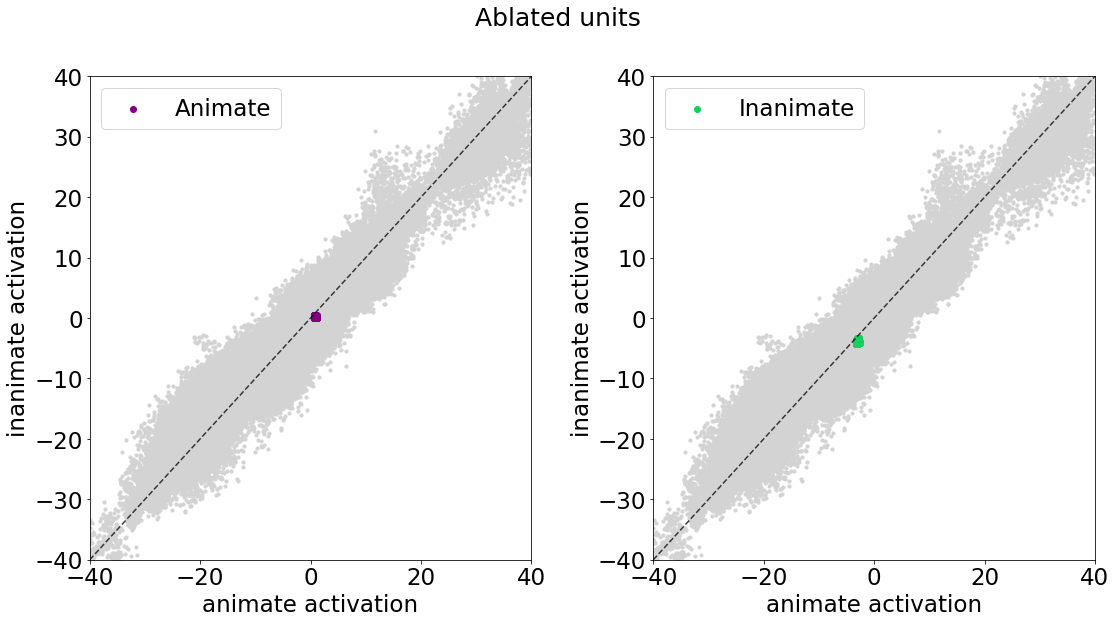

In [25]:
fig, ax = plt.subplots(figsize=(16,9))
matplotlib.rcParams["font.size"] = 23
fig.suptitle('Ablated units', fontsize=25)


plt.subplot(1, 2, 1)
plt.scatter(x,y, c='lightgray', s=10,vmin=-1, vmax=1)
plt.scatter(spax, spay, label='Animate',color='#800080')
plt.plot([-40,40],[-40,40], 'k--', color='black', alpha=0.75)
plt.xlim([-40,40])
plt.ylim([-40,40])
plt.ylabel('inanimate activation')
plt.xlabel('animate activation')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter( x,y, c='lightgray', s=10,vmin=-1, vmax=1)
plt.scatter(spix, spiy, color='#15CF5F', label='Inanimate')
plt.plot([-40,40],[-40,40], 'k--', color='black', alpha=0.75)
plt.xlim([-40,40])
plt.ylim([-40,40])
plt.ylabel('inanimate activation')
plt.xlabel('animate activation')

plt.legend()

plt.tight_layout()
#plt.savefig('../../results/mobile_scatter.png')

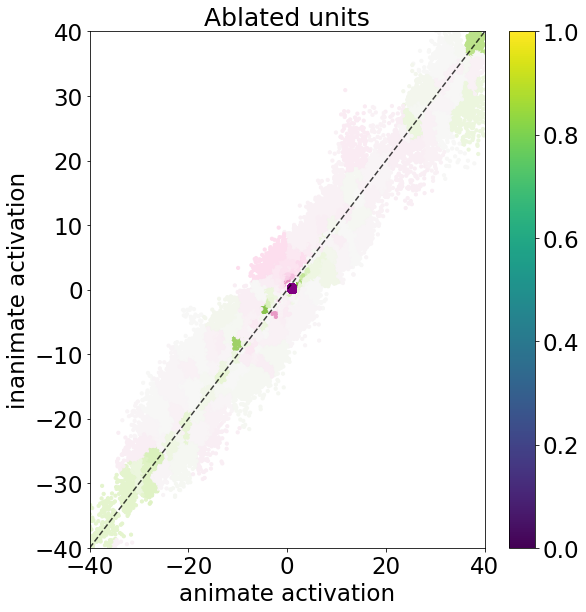

In [26]:
fig, ax = plt.subplots(figsize=(16,9))
matplotlib.rcParams["font.size"] = 23


plt.subplot(1, 2, 1)
plt.scatter(x,y, c=z, s=10,vmin=-1, vmax=1,cmap='PiYG')
plt.scatter(spax, spay, label='Animate',color='#800080')
plt.plot([-40,40],[-40,40], 'k--', color='black', alpha=0.75)
plt.xlim([-40,40])
plt.ylim([-40,40])
plt.ylabel('inanimate activation')
plt.xlabel('animate activation')


#plt.legend()
plt.colorbar()
plt.title('Ablated units', fontsize=25)
plt.tight_layout()
#plt.savefig('../../results/mobile_scatter.png')

In [ ]:
#To check for units that are selectively shared between animate and inanimate category
list(set(np.where(z== result[ana_256])[0]) & set(np.where(z== result[ina_512])[0]))

In [27]:
%time
global debug
debug = False
layer_info = {}
#Comparing Layer lesions
classes = ['animate','inanimate']
folder ='pkl_mobile'
#classes = ['T1A','T1B']
#folder ='pkl_test_1'

layer_info[label] = {}
#Before lesion
#print('Pre-layer-lesioning')
#print('Label:',label)
#print('Layer:',layer)

pred = clf.predict(X_new)
loc = np.where(pred==label)[0]
loc_new =[]
for i in range(len(loc)):
    temp = np.where(pred_kmeans==loc[i])[0]
    loc_new.extend(temp)

lambda_mask = np.ones(shape=((5725552,)))
print('no', '0')
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)

flag = 0
dprime = 0.
for p in classes:
    im_valid_test = []
    image_list_valid = '../../data/'+folder+'/'+p+'_'+str(model_name)+'_image_list_test.txt'
    with open(image_list_valid,'r') as f:
        for line in f.readlines():
            im_valid_test.append(line.strip('\n'))
    im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
    out = model.predict(im_temp,batch_size=64)

    true_valid_wids = []
    for i in im_valid_test:
            temp1 = i.split('/')[4]
            temp = temp1.split('.')[0].split('_')[2]
            true_valid_wids.append(truth[int(temp)][1])

    predicted_valid_wids = []
    for i in range(len(im_valid_test)):
        #print im_list[i], pprint_output(out[i]), true_wids[i]
        predicted_valid_wids.append(pprint_output(out[i]))

    count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

    print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

    if flag == 0:
        dprime = error
        flag = 1
    else:
        dprime -= error
print('No Lesion: ',dprime)
layer_info[label]['no'] = dprime   
keras.backend.clear_session()
gc.collect()
del model

#Animate lesion
#print('Pre-layer-lesioning')
#print('Label:',label)
#print('Layer:',layer)(

pred = clf.predict(X_new)
loc = np.where(pred==label)[0]
loc_new =[]
for i in range(len(loc)):
    temp = np.where(pred_kmeans==loc[i])[0]
    loc_new.extend(temp)

lambda_mask = np.ones(shape=((5725552,)))
lambda_mask[loc_ana_avg] = 0.
print('ana-loc', len(loc_ana_avg))
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)

flag = 0
dprime = 0.
for p in classes:
    im_valid_test = []
    image_list_valid = '../../data/'+folder+'/'+p+'_'+str(model_name)+'_image_list_test.txt'
    with open(image_list_valid,'r') as f:
        for line in f.readlines():
            im_valid_test.append(line.strip('\n'))
    im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
    out = model.predict(im_temp,batch_size=64)

    true_valid_wids = []
    for i in im_valid_test:
            temp1 = i.split('/')[4]
            temp = temp1.split('.')[0].split('_')[2]
            true_valid_wids.append(truth[int(temp)][1])

    predicted_valid_wids = []
    for i in range(len(im_valid_test)):
        #print im_list[i], pprint_output(out[i]), true_wids[i]
        predicted_valid_wids.append(pprint_output(out[i]))

    count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

    print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

    if flag == 0:
        dprime = error
        flag = 1
    else:
        dprime -= error
print('Animate lesion: ',dprime)
layer_info[label][''] = dprime   
keras.backend.clear_session()
gc.collect()
del model

#InAnimate lesion
#print('Pre-layer-lesioning')
#print('Label:',label)
#print('Layer:',layer)

pred = clf.predict(X_new)
loc = np.where(pred==label)[0]
loc_new =[]
for i in range(len(loc)):
    temp = np.where(pred_kmeans==loc[i])[0]
    loc_new.extend(temp)

lambda_mask = np.ones(shape=((5725552,)))
lambda_mask[loc_ina_avg] = 0.
print('ina-loc', len(loc_ina_avg))
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)

flag = 0
dprime = 0.
for p in classes:
    im_valid_test = []
    image_list_valid = '../../data/'+folder+'/'+p+'_'+str(model_name)+'_image_list_test.txt'
    with open(image_list_valid,'r') as f:
        for line in f.readlines():
            im_valid_test.append(line.strip('\n'))
    im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
    out = model.predict(im_temp,batch_size=64)

    true_valid_wids = []
    for i in im_valid_test:
            temp1 = i.split('/')[4]
            temp = temp1.split('.')[0].split('_')[2]
            true_valid_wids.append(truth[int(temp)][1])

    predicted_valid_wids = []
    for i in range(len(im_valid_test)):
        #print im_list[i], pprint_output(out[i]), true_wids[i]
        predicted_valid_wids.append(pprint_output(out[i]))

    count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

    print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

    if flag == 0:
        dprime = error
        flag = 1
    else:
        dprime -= error
print('Inanimate lesion: ',dprime)
layer_info[label][''] = dprime   
keras.backend.clear_session()
gc.collect()
del model

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.15 µs
no 0
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
No Lesion:  -0.05128205128205132
ana-loc 77917
animate 0 39 1.0 0.0
inanimate 30 39 0.23076923076923073 0.7692307692307693
Animate lesion:  0.7692307692307693
ina-loc 5716
animate 31 39 0.20512820512820518 0.7948717948717948
inanimate 13 39 0.6666666666666667 0.33333333333333326
Inanimate lesion:  -0.46153846153846156


In [28]:
import gc
keras.backend.clear_session()
gc.collect()
if 'model' in locals():
    del model

# Step 2.1 - Salience score experiments

In [29]:
#Activation plot with Salience
lambda_mask = np.ones(shape=((5725552,)))
# print(len(loc_ana_avg),' out of 5725552')
# lambda_mask[loc_ana_avg] = 0.
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                    weights="imagenet",input_tensor=None, pooling=None, 
                    classes=1000, classifier_activation="softmax", lambda_mask=lambda_mask)

layer_idx = vis_utils.find_layer_idx(model, 'Logits')
model.layers[layer_idx].activation = keras.activations.linear

analyzer = innvestigate.create_analyzer("gradient", model,reverse_keep_tensors=True,allow_lambda_layers =True)

image_list_valid = '../../data/pkl_mobile/animate_MobileNetV2_image_list_test.txt'
im_valid_test = []
with open(image_list_valid,'r') as f:
    for line in f.readlines():
        im_valid_test.append(line.strip('\n'))

all_data = []
for image_name in im_valid_test[0:2]:
    x = preprocess_image_batch([image_name],img_size=(256,256), crop_size=(224,224), color_mode="rgb")
    a = analyzer.analyze(x)

    data = []# Step 2.1 - Salience score experiments

    for k, v in analyzer._reversed_tensors:
        weights = model.layers[k[0]].get_weights()
        if len(weights) > 0:
            if model.layers[k[0]].name != 'Logits' and not model.layers[k[0]].name.startswith('lambda'):
                temp = np.mean(v, axis=0).ravel()
                data = np.append(data, temp)
    all_data.append(data)
all_data = np.asarray(all_data)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


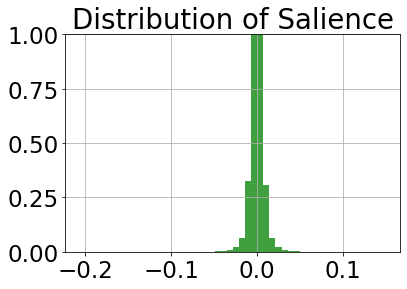

In [30]:
z_sal = np.mean(all_data, axis=0)
n, bins, patches = plt.hist(z_sal,50, density=True, facecolor='g', alpha=0.75)

plt.ylim([0,1])
#plt.xlim([-0.07,0.07])
plt.title('Distribution of Salience')
plt.grid(True)
plt.show()

In [31]:
print(max(z_sal),min(z_sal))
#print(sorted(z_sal)[::-1][0:50])

0.14904988859780133 -0.20555119216442108


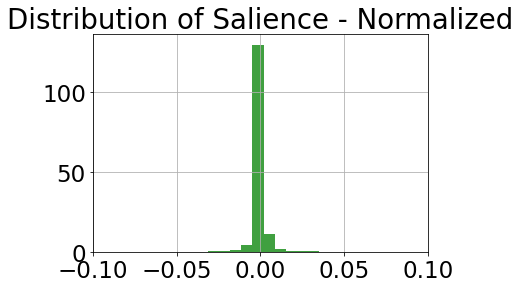

In [32]:
abs_max = np.amax(np.abs(z_sal))
z_sal_norm = z_sal * (1.0 / abs_max)
n, bins, patches = plt.hist(z_sal_norm,260, density=True, facecolor='g', alpha=0.75)

#plt.ylim([0,1])
plt.xlim([-0.1,0.1])
plt.title('Distribution of Salience - Normalized')
plt.grid(True)
plt.show()

In [33]:
print(max(z_sal_norm),min(z_sal_norm))

0.725122958560006 -1.0


In [34]:
sal_ana_avg = np.where((z_sal_norm < -0.022) | (z_sal_norm > 0.022))[0]
print(len(sal_ana_avg), len(list(set(sal_ana_avg) & set(loc_ana_avg))), \
     len(list(set(sal_ana_avg) & set(loc_ina_avg))))

73718 208 18


In [35]:
sal_ina_avg = np.where((z_sal_norm < -0.05) | (z_sal_norm > 0.05))[0]
print(len(sal_ina_avg), len(list(set(sal_ina_avg) & set(loc_ana_avg))), \
     len(list(set(sal_ina_avg) & set(loc_ina_avg))))

16582 14 4


In [36]:
lambda_mask = np.ones(shape=((5725552,)))
print(len(sal_ana_avg),' out of 5725552')
lambda_mask[sal_ana_avg] = 0.
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                    weights="imagenet",input_tensor=None, pooling=None, 
                    classes=1000, classifier_activation="softmax", lambda_mask=lambda_mask)

flag = 0
dprime = 0.
for p in classes:
    im_valid_test = []
    image_list_valid = '../../data/'+folder+'/'+p+'_'+str(model_name)+'_image_list_test.txt'
    with open(image_list_valid,'r') as f:
        for line in f.readlines():
            im_valid_test.append(line.strip('\n'))
    im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
    out = model.predict(im_temp,batch_size=64)
    true_valid_wids = []
    for i in im_valid_test:
            temp1 = i.split('/')[4]
            temp = temp1.split('.')[0].split('_')[2]
            true_valid_wids.append(truth[int(temp)][1])

    predicted_valid_wids = []
    for i in range(len(im_valid_test)):
        #print im_list[i], pprint_output(out[i]), true_wids[i]
        predicted_valid_wids.append(pprint_output(out[i]))

    count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

    print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

    if flag == 0:
        dprime = error
        flag = 1
    else:
        dprime -= error
print('Salience lesion: ',dprime)  
keras.backend.clear_session()
gc.collect()
del model

'''
Salience Inanimate Lesion

animate 11 39 0.717948717948718 0.28205128205128205
inanimate 17 39 0.5641025641025641 0.4358974358974359
Salience lesion:  0.15384615384615385

Salience Animate Lesion

animate 21 39 0.46153846153846156 0.5384615384615384
inanimate 22 39 0.4358974358974359 0.5641025641025641
Salience lesion:  0.02564102564102566
'''

73718  out of 5725552
animate 1 39 0.9743589743589743 0.02564102564102566
inanimate 0 39 1.0 0.0
Salience lesion:  -0.02564102564102566


'\nSalience Inanimate Lesion\n\nanimate 11 39 0.717948717948718 0.28205128205128205\ninanimate 17 39 0.5641025641025641 0.4358974358974359\nSalience lesion:  0.15384615384615385\n\nSalience Animate Lesion\n\nanimate 21 39 0.46153846153846156 0.5384615384615384\ninanimate 22 39 0.4358974358974359 0.5641025641025641\nSalience lesion:  0.02564102564102566\n'

# Step 2.2 - representation dissimilarity score experiments (RDS)

In [ ]:
# Create Animate template RDM
animate_template_RDM = np.zeros((78,78))
for i in range(39):
    for j in range(39):
        animate_template_RDM[i][j] = 1
plt.imshow(animate_template_RDM)

In [ ]:
# Create Inanimate template RDM
inanimate_template_RDM = np.zeros((78,78))
for i in range(39,78):
    for j in range(39,78):
        inanimate_template_RDM[i][j] = 1
plt.imshow(inanimate_template_RDM)

In [ ]:
#Testing data pkl - animate
im_test = []
data_animate_activations = []
image_list_test = '../../data/pkl_mobile/animate_image_list_test.txt'
with open(image_list_test,'rb') as f:
    for line in f.readlines():
        im_test.append(line.strip('\n'))

im_temp = preprocess_image(im_test,227,227, color_mode="bgr")
out = model.predict(im_temp,batch_size=64)

true_valid_wids = []
for i in im_test:
        temp1 = i.split('/')[4]
        temp = temp1.split('.')[0].split('_')[2]
        true_valid_wids.append(truth[int(temp)][1])

flag =0      
total = 0
for j in range(len(im_test)):
    im_temp = preprocess_image([im_test[j]],227,227, color_mode="bgr")
    out = model.predict(im_temp,batch_size=64)
    
    predicted_valid_wids = []
    #print im_list[i], pprint_output(out[i]), true_wids[i]
    predicted_valid_wids.append(pprint_output(out[0]))
        
    count, error  = top5accuracy([true_valid_wids[j]], predicted_valid_wids)

    total += count
    #print true_valid_wids[j], predicted_valid_wids[0]


    #}ltauResult(correlation=0.2664768530504399, p
    # Code snippet to get the activation values and saving information{
    data = np.array([])


    i = 0
    result ={}
    for layer in model.layers:
        weights = layer.get_weights()
        if len(weights) > 0:
            activations = get_activations(model,i,im_temp)
            if result.get(layer.name, None) is None:
                result[layer.name] = activations[0]
                if len(activations[0].shape) == 4:
                    temp = activations[0].reshape(activations[0].shape[0], activations[0].shape[1]*activations[0].shape[2]*activations[0].shape[2])
                else:
                    temp = activations[0].reshape(activations[0].shape[0], activations[0].shape[1])
                if layer.name != 'dense_3':
                    #print layer.name,len(weights),len(activations), activations[0].shape, np.mean(activations[0], axis=0).shape, temp.shape
                    if len(data) == 0:
                        data = temp
                    else:
                        shape = data.shape
                        data = np.append(data, temp)
                        data = data.reshape(shape[0], shape[1] + temp.shape[1])
        i += 1
    if flag == 0:
        data_animate_activations = data
        flag = 1
    else:
        data_animate_activations = np.append(data_animate_activations,data, axis =0)

In [ ]:
#Testing data pkl - Inanimate
im_test = []
data_inanimate_activations = []
image_list_test = '../../data/pkl_alex/inanimate_image_list_test.txt'
with open(image_list_test,'rb') as f:
    for line in f.readlines():
        im_test.append(line.strip('\n'))

        
true_valid_wids = []
for i in im_test:
        temp1 = i.split('/')[4]
        temp = temp1.split('.')[0].split('_')[2]
        true_valid_wids.append(truth[int(temp)][1])

flag =0      
total = 0
for j in range(len(im_test)):
    im_temp = preprocess_image([im_test[j]],227,227, color_mode="bgr")
    out = model.predict(im_temp,batch_size=64)
    
    predicted_valid_wids = []
    #print im_list[i], pprint_output(out[i]), true_wids[i]
    predicted_valid_wids.append(pprint_output(out[0]))
        
    count, error  = top5accuracy([true_valid_wids[j]], predicted_valid_wids)

    total += count
    #print true_valid_wids[j], predicted_valid_wids[0]


    #}
    # Code snippet to get the activation values and saving information{
    data = np.array([])


    i = 0
    result ={}
    for layer in model.layers:
        weights = layer.get_weights()
        if len(weights) > 0:
            activations = get_activations(model,i,im_temp)
            if result.get(layer.name, None) is None:
                result[layer.name] = altauResult(correlation=0.2664768530504399, pctivations[0]
                if len(activations[0].shape) == 4:
                    temp = activations[0].reshape(activations[0].shape[0], activations[0].shape[1]*activations[0].shape[2]*activations[0].shape[2])
                else:
                    temp = activations[0].reshape(activations[0].shape[0], activations[0].shape[1])
                if layer.name != 'dense_3':
                    #print layer.name,len(weights),len(activations), activations[0].shape, np.mean(activations[0], axis=0).shape, temp.shape
                    if len(data) == 0:
                        data = temp
                    else:
                        shape = data.shape
                        data = np.append(data, temp)
                        data = data.reshape(shape[0], shape[1] + temp.shape[1])
        i += 1
    if flag == 0:
        data_inanimate_activations = data
        flag = 1
    else:
        data_inanimate_activations = np.append(data_inanimate_activations,data, axis =0)
    
print(data_inanimate_activations.shape, total, len(im_test))

In [ ]:
data_cluster_animate = {}
data_cluster_inanimate = {}
data_cluster = {}


for label in range(len(labels)):
    pred = clf.predict(X_new)
    loc = np.where(pred==label)[0]
    loc_new =[]
    for i in range(len(loc)):
        temp = np.where(pred_kmeans==loc[i])[0]
        loc_new.extend(temp)

    
    index_cluster = loc_new
    
    #Animate
    #data_temp = data_animate_activations.copy()
    #for i in data_temp:
    #    i[loc_new] = 0.
    data_temp = data_animate_activations[:,loc_new]
    correlation_mat= 1 - np.corrcoef(data_temp)
    #data_shape = correlation_mat.shape
    #arr_sorted =  sorted(correlation_mat.ravel())
    #s = pd.Series(correlation_mat.ravel())
    #percentiles = np.asarray(s.apply(lambda x: percentileofscore(arr_sorted, x)))
    #data_temp = np.reshape(percentiles, data_shape)
    data_cluster_animate[label] = correlation_mat
    
    #InAnimate
    #data_temp = data_inanimate_activations.copy()
    #for i in data_temp:
    #    i[loc_new] = 0.
    data_temp = data_inanimate_activations[:,loc_new]
    correlation_mat= 1 - np.corrcoef(data_temp)
    #data_shape = correlation_mat.shape
    #arr_sorted =  sorted(correlation_mat.ravel())
    #s = pd.Series(correlation_mat.ravel())
    #percentiles = np.asarray(s.apply(lambda x: percentileofscore(arr_sorted, x)))
    #data_temp = np.reshape(percentiles, data_shape)
    data_cluster_inanimate[label] = correlation_mat
    
    #Total
    data_temp = np.concatenate((data_animate_activations[:,loc_new],data_inanimate_activations[:,loc_new]))
    correlation_mat= 1 - np.corrcoef(data_temp)
    #data_shape = correlation_mat.shape
    #arr_sorted =  sorted(correlation_mat.ravel())
    #s = pd.Series(correlation_mat.ravel())
    #percentiles = np.asarray(s.apply(lambda x: percentileofscore(arr_sorted, x)))
    #data_temp = np.reshape(percentiles, data_shape)
    data_cluster[label] = correlation_mat

In [ ]:
rdm_impact ={}

for label in range(len(labels)):
    #if labels[label] != 0.:
    t_ana, p_ana = stats.kendalltau(data_full_animate,data_cluster_animate[label])
    t_ina, p_ina = stats.kendalltau(data_full_inanimate,data_cluster_inanimate[label])
    t, p = stats.kendalltau(data_cluster_animate[label], data_cluster_inanimate[label])
    diff = float(t_ana - t_ina)
    rdm_impact[label] = p_ina
    print(label, labels[label], t_ana, t_ina)
    

# Step 3 - Generating Salience figures

In [ ]:
#Pre-trained model - Without lesion
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                    weights="imagenet",input_tensor=None, pooling=None, 
                    classifier_activation="softmax", classes=1000)

In [ ]:
#Pre-trained model - With lesion
'''
label=ana
#print(label,result[label])
pred = clf.predict(X_new)
loc = np.where(pred==label)
loc_temp = kmeans.predict(X_new[loc[0]])
loc_new =[]
for entry in set(loc_temp):
    temp = np.where(pred_kmeans==entry)[0]
    loc_new.extend(temp)
'''
lambda_mask = np.ones(shape=((5725552,)))
print(len(loc_ana_avg),' out of 5725552')
lambda_mask[loc_ana_avg] = 0.
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                    weights="imagenet",input_tensor=None, pooling=None, 
                    classes=1000, classifier_activation="softmax", lambda_mask=lambda_mask)

In [ ]:
image_list_valid = '../../data/pkl_mobile/animate_MobileNetV2_image_list_test.txt'
im_valid_test = []
with open(image_list_valid,'r') as f:
    for line in f.readlines():
        im_valid_test.append(line.strip('\n'))
        
im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
out = model.predict(im_temp,batch_size=64)

true_valid_wids = []
for i in im_valid_test:
        temp1 = i.split('/')[4]
        temp = temp1.split('.')[0].split('_')[2]
        true_valid_wids.append(truth[int(temp)][1])

predicted_valid_wids = []
for i in range(len(im_valid_test)):
    #print im_list[i], pprint_output(out[i]), true_wids[i]
    predicted_valid_wids.append(pprint_output(out[i]))

count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

print(len(true_valid_wids), len(predicted_valid_wids), len(im_valid_test))
print(count, error)
c=0
w=0
flag  = 0
for i in range(len(true_valid_wids)):
    flag  = 0
    temp = true_valid_wids[i]
    for j in predicted_valid_wids[i][0:5]:
        if j == temp:
            flag = 1
            break
    if flag == 1:
        c +=1
        print(i,'1 - Correct')
    else:
        w+=1
        print(i,'0 - Wrong')
print(c,w)

In [ ]:
image_name = im_valid_test[9]
_img = load_img(image_name,target_size=(224,224))
plt.imshow(_img)

In [ ]:
layer_idx = vis_utils.find_layer_idx(model, 'Logits')
model.layers[layer_idx].activation = keras.activations.linear

In [ ]:
# Get model
# Strip softmax layer
#model = innvestigate.utils.model_wo_softmax(model)

# Create analyzer
analyzer = innvestigate.create_analyzer("gradient", model,reverse_keep_tensors=True,allow_lambda_layers =True)

In [ ]:
# Add batch axis and preprocess
image_name = im_valid_test[9]
x = preprocess_image_batch([image_name],img_size=(256,256), crop_size=(224,224), color_mode="rgb")
print(x.shape)
# Apply analyzer w.r.t. maximum activated output-neuron
a = analyzer.analyze(x)

# Aggregate along color channels and normalize to [-1, 1]
a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
a /= np.max(np.abs(a))
# Plot
plt.imshow(a[0], cmap="seismic", clim=(-1, 1))
plt.axis('off')

In [ ]:
no_specific_impact_idx = 4
no_impact_idx = 5
animate_impact_idx = 1
inanimate_impact_idx = 2

In [ ]:
import matplotlib.gridspec as gridspec

#fig = plt.figure(figsize=(8, 24),constrained_layout=True) #figsize - width,height
fig = plt.figure(figsize=(16, 8),constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=4/72,h_pad=4/72, hspace=0, wspace=0)
spec = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
original_flag = 0
row= column = 0
for high_impact_cluster in [-1,1,2]:
    if high_impact_cluster == -1:
        row = 0
        column = 1 
        #Pre-trained model - Without lesion
        model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                            weights="imagenet",input_tensor=None, pooling=None, 
                    classifier_activation="softmax", classes=1000)
    elif high_impact_cluster == 1:
        row = 0
        column = 2
        lambda_mask = np.ones(shape=((5725552,)))
        #print(len(loc_new),' out of 5725552')
        lambda_mask[loc_ana_avg] = 0.
        model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                            weights="imagenet",input_tensor=None, pooling=None, 
                            classes=1000, classifier_activation="softmax", lambda_mask=lambda_mask)
    elif high_impact_cluster == 2:
        row = 0
        column = 3
        lambda_mask = np.ones(shape=((5725552,)))
        #print(len(loc_new),' out of 5725552')
        lambda_mask[loc_ina_avg] = 0.
        model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                            weights="imagenet",input_tensor=None, pooling=None, 
                            classes=1000, classifier_activation="softmax", lambda_mask=lambda_mask)
    else:
        #Pre-trained model - With lesion
        row =  0
        if high_impact_cluster == 1:
            column = 2
        elif high_impact_cluster == 2:
            column = 3
        elif high_impact_cluster == no_impact_idx:
            column = 2
        elif high_impact_cluster == no_specific_impact_idx:
            column = 3
        elif high_impact_cluster == animate_impact_idx:
            column = 4
        else:
            column = 5
        label=high_impact_cluster
        print(label,result[label])
        pred = clf.predict(X_new)
        loc = np.where(pred==label)
        loc_temp = kmeans.predict(X_new[loc[0]])
        loc_new =[]
        for entry in set(loc_temp):
            temp = np.where(pred_kmeans==entry)[0]
            loc_new.extend(temp)

        lambda_mask = np.ones(shape=((5725552,)))
        #print(len(loc_new),' out of 5725552')
        lambda_mask[loc_new] = 0.
        model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                            weights="imagenet",input_tensor=None, pooling=None, 
                            classes=1000, classifier_activation="softmax", lambda_mask=lambda_mask)
        
    layer_idx = vis_utils.find_layer_idx(model, 'Logits')
    model.layers[layer_idx].activation = keras.activations.linear
    
    # Create analyzer
    analyzer = innvestigate.create_analyzer("gradient", model,reverse_keep_tensors=True,allow_lambda_layers =True)
    
    for class_label in ['animate','inanimate']:
        image_list_valid = '../../data/pkl_mobile/'+class_label+'_MobileNetV2_image_list_test.txt'
        im_valid_test = []
        with open(image_list_valid,'r') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))

        im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
        out = model.predict(im_temp,batch_size=64)

        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)
        print(high_impact_cluster, class_label)
        
        color = []
        line_style = []
        c=0
        w=0
        flag  = 0
        for i in range(len(true_valid_wids)):
            flag  = 0
            temp = true_valid_wids[i]
            for j in predicted_valid_wids[i][0:5]:
                if j == temp:
                    flag = 1
                    break
            if flag == 1:
                c +=1
                color.append('green')
                line_style.append('-.')
                #print(i,'1 - Correct')
            else:
                w+=1
                color.append('red')
                line_style.append('-')
                #print(i,'0 - Wrong')
        #print(c,w)
        
        for image_idx in range(23,24): #2,3 - 6,7 - 7,8
            _img = load_img(im_valid_test[image_idx],target_size=(224,224))
            if original_flag < 2:
                ax = fig.add_subplot(spec[row,0])
                ax.imshow(_img)
                ax.axis('off')
                ax.set_aspect('equal')     
                
            x = preprocess_image_batch([im_valid_test[image_idx]],img_size=(256,256), crop_size=(224,224), color_mode="rgb")
            #print(x.shape)
            # Apply analyzer w.r.t. maximum activated output-neuron
            a = analyzer.analyze(x)

            # Aggregate along color channels and normalize to [-1, 1]
            a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
            a /= np.max(np.abs(a))
            # Plot
            #print(row,column)
            ax = fig.add_subplot(spec[row,column])
            ax.imshow(a[0], cmap="seismic", clim=(-1, 1))
            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ax.spines.values():
                spine.set_edgecolor(color[image_idx])
                spine.set_linestyle(line_style[image_idx])
                spine.set_linewidth(4.)
            ax.set_aspect('equal')
            row += 1
            if high_impact_cluster == -1:
                column = 1
            elif high_impact_cluster == 1:
                column = 2
            elif high_impact_cluster == 2:
                column = 3
            elif high_impact_cluster == -1:
                column = 1
            elif high_impact_cluster == no_specific_impact_idx:
                column = 3
            elif high_impact_cluster == animate_impact_idx:
                column = 4
            elif high_impact_cluster == inanimate_impact_idx:
                column = 5
            else:
                column = 1
           
  
        if original_flag < 2:
            original_flag += 1
        '''
        print(len(true_valid_wids), len(predicted_valid_wids), len(im_valid_test))
        print(count, error)
        '''
        
        
    keras.backend.clear_session()
    gc.collect()
    del model
#plt.savefig('../../results/row-6.png', format='png')

# Step 4 - Representation analysis

In [10]:
folder = 'pkl_mobile'
model_name = 'MobileNetV2'
debug = False

In [11]:
# Activations
#%%time
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
#Testing on test data{
data_path = '../../data/'+folder+'/'
classes = ['animate','inanimate']

result = {}

with open(data_path+classes[0]+'_test_'+model_name+'.pkl','rb') as f:
        X_fold = pickle.load(f)
with open(data_path+classes[1]+'_test_'+model_name+'.pkl','rb') as f:
        y_fold = pickle.load(f)

X = np.column_stack((X_fold,y_fold))  
if os.path.exists('../../data/'+folder+'/kmeans_first_test_'+model_name+'.pkl'):
    with open('../../data/'+folder+'/kmeans_first_test_'+model_name+'.pkl',"rb") as f:
        X_new,pred_kmeans,kmeans = pickle.load(f)
else:   
   
    kmeans = MiniBatchKMeans(n_clusters=57255, #100x
                             random_state=42,
                             batch_size=6,
                             max_iter=10).fit(X)
    #print kmeans.cluster_centers_
    pred_kmeans = kmeans.predict(X)
    X_new = kmeans.cluster_centers_
    with open('../../data/'+folder+'/kmeans_first_test_'+model_name+'.pkl', 'wb') as handle:
        pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#MPPI for each unit calculation
mppi_result = {}
for label in list(set(pred_kmeans)):
    print('Label: ', label)

    loc_temp = kmeans.predict([X_new[500]])
    loc_new =[]
    temp = np.where(pred_kmeans==loc_temp)[0]
    loc_new.extend(temp)
    lambda_mask = np.ones(shape=((5725552,)))
    lambda_mask[loc_new] = 0.

    #plt.scatter(X[:,0],X[:,1], c=y_pred) 
    model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)
    flag = 0
    dprime = 0.
    for p in classes:
        im_valid_test = []
        image_list_valid = '../../data/'+folder+'/'+p+'_MobileNetV2_image_list_test.txt'
        with open(image_list_valid,'r') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))
        im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")

        out = model.predict(im_temp,batch_size=32)
       
        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

        print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

        if flag == 0:
            dprime = error
            flag = 1
        else:
            dprime -= error
    keras.backend.clear_session()
    gc.collect()
    del model

    mppi_result[label] = dprime

Label:  0
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  1
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  2
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  3
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  4
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  5
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  6
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  7
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  8
animate 35 39 0.10256410256410253 0.8974358974

Label:  69
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  70
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  71
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  72
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  73
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  74
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  75
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  76
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  77
animate 35 39 0.10256410256410253 0.8

inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  138
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  139
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  140
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  141
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  142
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  143
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  144
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  145
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.84

Label:  206
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  207
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  208
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  209
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  210
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  211
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  212
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  213
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  214
animate 35 39 0.102564102564

inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  275
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  276
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  277
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  278
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  279
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  280
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  281
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  282
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.84

Label:  343
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  344
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  345
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  346
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  347
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  348
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  349
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  350
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  351
animate 35 39 0.102564102564

inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  412
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  413
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  414
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  415
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  416
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  417
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  418
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  419
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.84

Label:  480
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  481
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  482
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  483
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  484
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  485
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  486
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  487
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  488
animate 35 39 0.102564102564

inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  549
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  550
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  551
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  552
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  553
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  554
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  555
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.8461538461538461
Label:  556
animate 35 39 0.10256410256410253 0.8974358974358975
inanimate 33 39 0.15384615384615385 0.84

In [40]:
# Create Animate template RDM
animate_template_RDM = np.zeros((78,78))
for i in range(39):
    for j in range(39):
        animate_template_RDM[i][j] = 1
plt.imshow(animate_template_RDM)

(57255, 2)

In [ ]:
# Create Inanimate template RDM
inanimate_template_RDM = np.zeros((78,78))
for i in range(39,78):
    for j in range(39,78):
        inanimate_template_RDM[i][j] = 1
plt.imshow(inanimate_template_RDM)

In [ ]:
#RDS for each unit calculation
rds_result ={}
for label in list(set(pred_kmeans)):
    print('Label: ', label)

    loc_temp = kmeans.predict([X_new[label]])
    loc_new =[]
    temp = np.where(pred_kmeans==loc_temp)[0]
    loc_new.extend(temp)
    lambda_mask = np.ones(shape=((5725552,)))
    lambda_mask[loc_new] = 0.

    #plt.scatter(X[:,0],X[:,1], c=y_pred) 
    model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)
    dprime = 0.
    for p in classes:
        im_valid_test = []
        image_list_valid = '../../data/'+folder+'/'+p+'_MobileNetV2_image_list_test.txt'
        with open(image_list_valid,'r') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))

        #Cluster RDM
        cluster_activations = []
        flag =0      
        total = 0
        t_result = {}
        for j in range(len(im_valid_test)):
            im_temp = preprocess_image([im_test[j]],227,227, color_mode="bgr")
            data = np.array([])

            i = 0
            for layer in model.layers:
                weights = layer.get_weights()
                if len(weights) > 0:
                    activations = get_activations(model,i,im_temp)
                    if t_result.get(layer.name, None) is None:
                        t_result[layer.name] = activations[0]
                        if len(activations[0].shape) == 4:
                            temp = activations[0].reshape(activations[0].shape[0], activations[0].shape[1]*activations[0].shape[2]*activations[0].shape[2])
                        else:
                            temp = activations[0].reshape(activations[0].shape[0], activations[0].shape[1])
                        if layer.name != 'Logits':
                            if len(data) == 0:
                                data = temp
                            else:
                                shape = data.shape
                                data = np.append(data, temp)
                                data = data.reshape(shape[0], shape[1] + temp.shape[1])
                i += 1
            if flag == 0:
                cluster_activations = data
                flag = 1
            else:
                cluster_activations = np.append(cluster_activations,data, axis =0)
                
        cluster_RDM = 1 - np.corrcoef(cluster_activations)
        
        if p =='animate':
            dprime = stats.kendalltau(cluster_RDM,animate_template_RDM)
        elif p == 'inanimate':
            dprime -= stats.kendalltau(cluster_RDM,inanimate_template_RDM)
    keras.backend.clear_session()
    gc.collect()
    del model

    rds_result[label] = dprime
    

In [ ]:
#Calculate the Percent Proportional Performance Impact
animate_percent_result = {}
inanimate_percent_result = {}
for percent in  [0.01,0.05,0.1,0.25,0.5,0.75,1.]:
    sorted_index = sorted(range(len(mppi_result)), key=lambda k: mppi_result[k])
    constrained_list = sorted_index[0:int(percent * len(mppi_result))]
    
    loc_temp = kmeans.predict([X_new[constrained_list]])
    loc_new =[]
    for entry in loc_temp:
        temp = np.where(pred_kmeans==entry)[0]
        loc_new.extend(temp)
    lambda_mask = np.ones(shape=((5725552,)))
    lambda_mask[loc_new] = 0.

    #plt.scatter(X[:,0],X[:,1], c=y_pred) 
    model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, weights="imagenet",input_tensor=None, pooling=None, classes=1000, classifier_activation="softmax", lambda_mask = lambda_mask)
    flag = 0
    for p in classes:
        im_valid_test = []
        image_list_valid = '../../data/'+folder+'/'+p+'_MobileNetV2_image_list_test.txt'
        with open(image_list_valid,'r') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))
        im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")

        out = model.predict(im_temp,batch_size=32)
       
        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

        print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))
        if p =='animate':
            animate_percent_result[percent] = float(count) / float(len(im_valid_test))
        elif p =='inanimate':
            inanimate_percent_result[percent] = float(count) / float(len(im_valid_test))
    keras.backend.clear_session()
    gc.collect()
    del model


In [ ]:
#Plotting the performance impact score based on MPPI proportioonal selection
plt.figure(figsize=(9,9))


x_axis = list(animate_percent_result.keys())
y_axis = [animate_percent_result[i] for i in x_axis]


# x_axis = list(inanimate_percent_result.keys())
# y_axis = [inanimate_percent_result[i] for i in x_axis]

plt.plot(x_axis, y_axis)
plt.xlim([0,1])
plt.ylim([0,1])